<a href="https://colab.research.google.com/github/Glebzok/AudioSegmentation/blob/master/Frame_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

## Prepare GoogleDrive

In [0]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
% cd ..
! cp -rf '/content/gdrive/My Drive/colab/Frame_Classification' .
% cd Frame_Classification

/
/Frame_Classification


In [0]:
! pip install wavio
! pip install soundfile

## Imports

In [0]:
import os
import numpy as np
from core import read_meta_yaml
import wave
import contextlib
import wavio
from scipy import signal
import matplotlib.pyplot as plt
from itertools import groupby

## Env Variables

In [0]:
events_folder = './audio_data/events'
bgs_folder = './audio_data/bgs/audio'
events_meta_folder = './audio_data/cv_setup/events_evaltest.yaml'

In [0]:
WINDOW_WIDTH = 5e-1 #s
SAMPLE_RATE = 44100
SPECTROGRAM_HEIGH = 129
SPECTROGRAM_WIDTH = int(WINDOW_WIDTH * SAMPLE_RATE / 225)

## Data Generators

In [0]:
class_labels = os.listdir(events_folder) + ['bg']
class_labels

['knock', 'clearthroat', 'keys', 'bg']

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx

{'bg': 3, 'clearthroat': 1, 'keys': 2, 'knock': 0}

In [0]:
idx_to_class = {class_to_idx[c]: c for c in class_to_idx.keys()}
idx_to_class

{0: 'knock', 1: 'clearthroat', 2: 'keys', 3: 'bg'}

In [0]:
def get_duration(wav_file_name):
    with contextlib.closing(wave.open(wav_file_name,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        return duration

In [0]:
def get_one_class_generator(class_name, debug=False):
    while True:
        if class_name == 'bg':
            for file in os.listdir(bgs_folder):
                duration = get_duration(bgs_folder+'/'+file)
                
                if duration < WINDOW_WIDTH:
                    continue
                
                onset = np.random.random(1) * (duration - WINDOW_WIDTH)
                offset = onset + WINDOW_WIDTH
                yield class_name, bgs_folder+'/'+file, float(onset), float(offset)
                
            if debug:
                print(class_name, "is done, starting from the beginning...")
        else:
            for file in read_meta_yaml(events_meta_folder)[class_name]:
                
                if file['segment'][1] - file['segment'][0] < WINDOW_WIDTH:
                    continue
                
                onset = file['segment'][0] + np.random.random(1) * (file['segment'][1] - file['segment'][0]- WINDOW_WIDTH)
                offset = onset + WINDOW_WIDTH
                yield class_name, events_folder + '/' + class_name + '/' + file['audio_filename'], float(onset), float(offset)
                
            if debug:
                print(class_name, "is done, starting from the beginning...")

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_one_class_generator(class_name, debug) for class_name in class_labels])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.__next__() for gen in generators[random_indices]]

In [0]:
def create_spectrogram_from_wav_file(wavfile_path, onset, offset):
    audio = wavio.read(wavfile_path).data
    if audio.shape[1] > 1:
        audio = np.sum(audio, axis = 1)
    else:
      audio = audio.reshape((-1,))
    if offset*SAMPLE_RATE > audio.shape[0]:
        audio_pad = np.random.random(int(SAMPLE_RATE * (offset - onset))) * np.mean(audio)
        audio_pad[:audio[int(onset*SAMPLE_RATE):].shape[0]] = audio[int(onset*SAMPLE_RATE):]
        samples = audio_pad
    else:
        samples = audio[int(onset*SAMPLE_RATE):int(offset*SAMPLE_RATE)]
    frequencies, times, spectrogram = signal.spectrogram(samples, SAMPLE_RATE)
#    fig=plt.figure(figsize=((5, 5)))
#    ax=fig.add_subplot(1,1,1)
#    plt.axis('off')
#    plt.pcolormesh(times, frequencies, np.log10(spectrogram+1e-20), figure = fig)
    return spectrogram

In [0]:
def data_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_data = []
        batch_labels = []
        for wav in batch:          
            batch_data.append(create_spectrogram_from_wav_file(wav[1], wav[2], wav[3]))
            batch_labels.append(wav[0])
        batch_data = np.stack(batch_data, axis=0)
        yield batch_data, batch_labels

## Train preparations

In [0]:
import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
def train_iterator(batch_size):
    for batch in data_and_labels_generator(batch_size):
        data = batch[0].astype('float32')
        data = data +  1e-21
        data = np.log10(data)
        data =  (((data - np.min(data)) * (1 - (-1))) / (np.max(data) - np.min(data))) + (-1)
        data = np.expand_dims(data, -1)
        labels = keras.utils.to_categorical(list(map(class_to_idx.get, batch[1])), NUM_CLASSES)
        yield data, labels

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization

In [0]:
from keras.metrics import categorical_crossentropy, categorical_accuracy

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + list(filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT)))[0]
print(GOOGLE_DRIVE_ROOT)

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/colab/Frame_Classification/model_{}"
print(CHECKPOINT_TEMPLATE)

/content/gdrive/My Drive
/content/gdrive/My Drive/colab/Frame_Classification/model_{}


# Архитектура

In [0]:
def make_model1():
   
    model = Sequential()
    
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(SPECTROGRAM_HEIGH, SPECTROGRAM_WIDTH, 1)))
    model.add(MaxPooling2D(pool_size=5, strides=2, padding = 'same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=5, strides=2, padding = 'same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=3, strides=2, padding = 'same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu'))
    model.add(MaxPooling2D(pool_size=3, strides=2, padding = 'same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='elu'))
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())

    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [0]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model1()
model.summary()

W0801 19:01:10.620259 139633692981120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0801 19:01:10.629579 139633692981120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0801 19:01:10.680700 139633692981120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 19:01:12.278655 139633692981120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W080

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 129, 98, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 65, 49, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 49, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 49, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 33, 25, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 25, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 25, 64)        18496     
__________

In [0]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = 100
EPOCHS = 100

s = reset_tf_session()  # clear default graph
model = make_model1()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy]
)
last_finished_epoch = 0

# Обучение

In [0]:
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

Epoch 1/100
100/100 [==============================] - 32s 323ms/step - loss: 0.2794 - categorical_accuracy: 0.8981
Model saved in /content/gdrive/My Drive/colab/Frame_Classification/model_0
Epoch 2/100
100/100 [==============================] - 31s 307ms/step - loss: 0.0841 - categorical_accuracy: 0.9719
Model saved in /content/gdrive/My Drive/colab/Frame_Classification/model_1
Epoch 3/100
100/100 [==============================] - 31s 310ms/step - loss: 0.0765 - categorical_accuracy: 0.9762
Model saved in /content/gdrive/My Drive/colab/Frame_Classification/model_2
Epoch 4/100
100/100 [==============================] - 31s 309ms/step - loss: 0.0516 - categorical_accuracy: 0.9816
Model saved in /content/gdrive/My Drive/colab/Frame_Classification/model_3
Epoch 5/100
100/100 [==============================] - 32s 315ms/step - loss: 0.0316 - categorical_accuracy: 0.9884
Model saved in /content/gdrive/My Drive/colab/Frame_Classification/model_4
Epoch 6/100
100/100 [========================

# Prediction

In [0]:
def test_iterator(batch_size, audio_path):
    audio_paths = []
    if os.path.isdir(audio_path):
        for inp_file in os.listdir(audio_path):
            audio_paths += [audio_path + inp_file]
    else:
        audio_paths += [audio_path] 
        
    audio_paths = [inp_file for inp_file in audio_paths if (inp_file[-4:]  == '.wav')]
    
    tracks = []

    batch_keys = []
    batch_data = []
    
    for j, inp_audio in enumerate(audio_paths):
        data = wavio.read(inp_audio).data
        if data.shape[1] > 1:
            data = np.sum(data, axis = 1)
        else:
          data = data.reshape((-1,))
        
        full_segments = (data.shape[0] /  float(SAMPLE_RATE)) // WINDOW_WIDTH
        if (data.shape[0] / float(SAMPLE_RATE)) % WINDOW_WIDTH != 0:
            full_segments += 1
        
        segments = []
        for i in range(int(full_segments)):
            

            batch_data.append(create_spectrogram_from_wav_file(inp_audio, i * WINDOW_WIDTH, (i+1)*WINDOW_WIDTH))
            batch_keys.append((inp_audio,i))
            if len(batch_data) == batch_size:
                
                batch_data = np.stack(batch_data, axis=0)
                batch_data = np.expand_dims(batch_data, -1)
                batch_data = batch_data.astype('float32')
                batch_data = batch_data +  1e-21
                batch_data = np.log10(batch_data)
                batch_data =  (((batch_data - np.min(batch_data)) * (1 - (-1))) / float(np.max(batch_data) - np.min(batch_data))) + (-1)
              
                yield batch_keys, batch_data
                batch_keys = []
                batch_data = []    
   
    if batch_data:  # last batch
        batch_data = np.stack(batch_data, axis=0)
        batch_data = np.expand_dims(batch_data, -1)
        batch_data = batch_data.astype('float32')
       
        batch_data = batch_data +  1e-21
        batch_data = np.log10(batch_data)
        batch_data =  (((batch_data - np.min(batch_data)) * (1 - (-1))) / float(np.max(batch_data) - np.min(batch_data))) + (-1)

        yield batch_keys, batch_data
        batch_keys = []
        batch_data = [] 

In [0]:
def predict(audio_path = './test_audio_folder/'):
    colors = ['r', 'g', 'b', 'y']
    
    keys = []
    classes = []
    
    for batch_keys, batch_data in test_iterator(BATCH_SIZE, audio_path):
        keys.append(batch_keys)
        classes.append(model.predict_classes(batch_data, BATCH_SIZE))

    classes = [c for batch in classes for c in batch]
    keys = [k for batch in keys for k in batch]
    
    keys_classes = list(zip(keys, classes))
    
    keys_classes.sort(key = lambda x : (x[0][0], x[0][1]))
    files = [list(g) for k, g in groupby(keys_classes, lambda s: s[0][0].partition('/')[-1])]
    for f in files:
        filename = f[0][0][0]
        window_classes = [i[1] for i in f]
        
        audio = wavio.read(filename).data
        if audio.shape[1] > 1:
            audio = np.sum(audio, axis = 1)
        else:
          audio = audio.reshape((-1,))

        plt.figure(figsize=(20,10))
        plt.title(filename)
        plt.plot(np.linspace(0, audio.shape[0], audio.shape[0]), audio)
        
        for i, window in enumerate(window_classes):
            lb = int(i * WINDOW_WIDTH * SAMPLE_RATE)
            rb = int(min(audio.shape[0], (i+1) * WINDOW_WIDTH * SAMPLE_RATE))
        
            plt.plot(np.linspace(0, audio.shape[0], audio.shape[0])[lb:rb], audio[lb:rb], label = idx_to_class[window], c = colors[window])
        
        handles, labels = plt.gca().get_legend_handles_labels()
        newLabels, newHandles = [], []
        for handle, label in zip(handles, labels):
            if label not in newLabels:
                newLabels.append(label)
                newHandles.append(handle)
        plt.legend(newHandles, newLabels)
        plt.xlabel('time (s)')

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


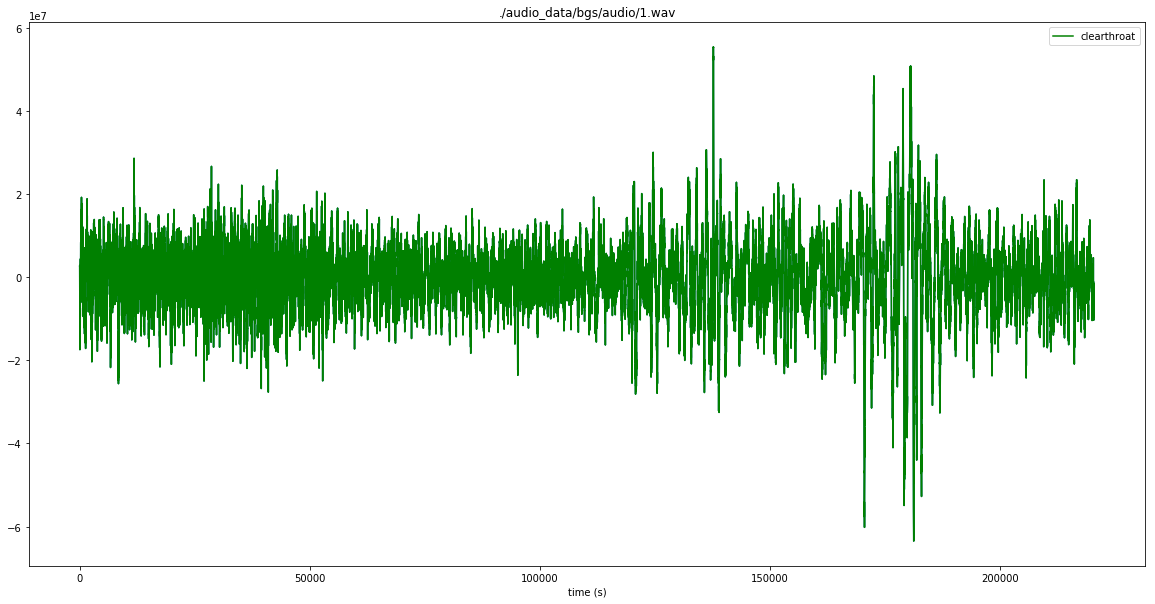

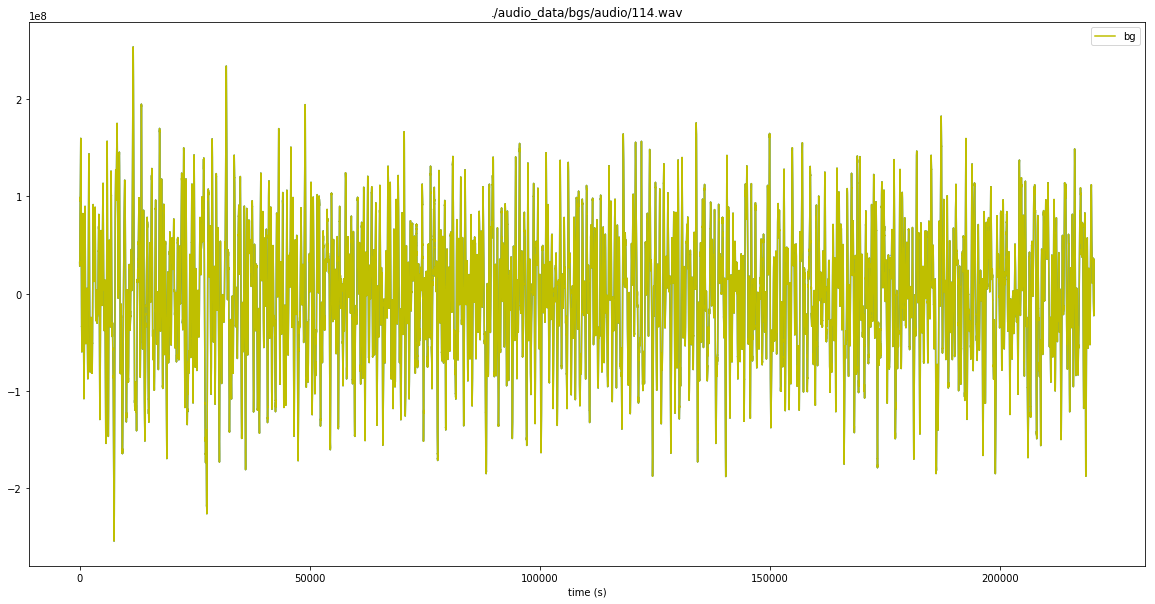

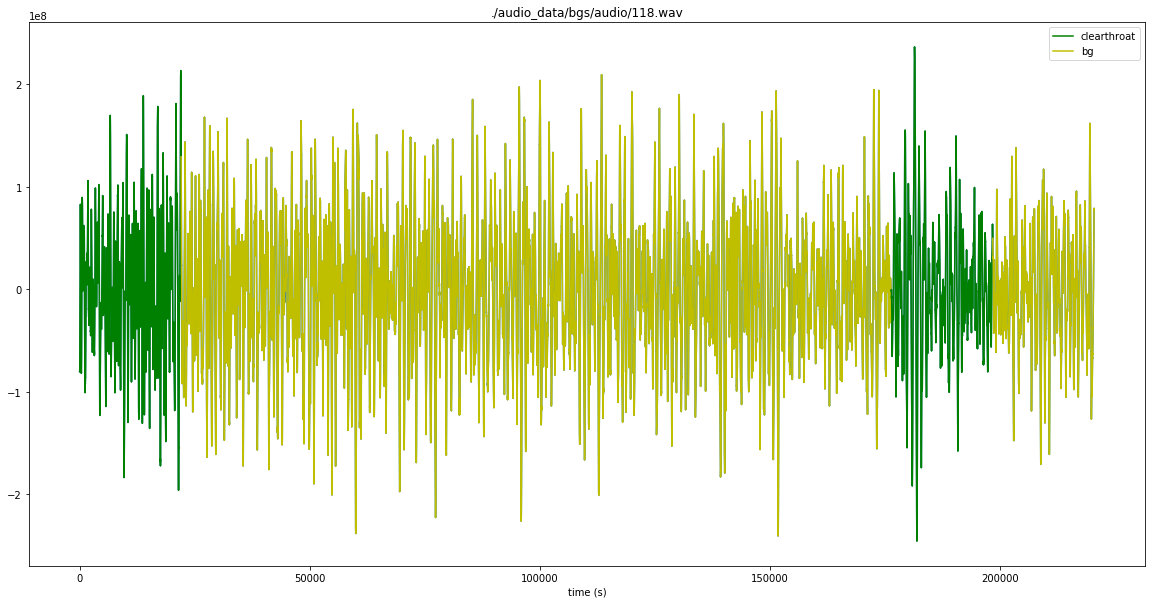

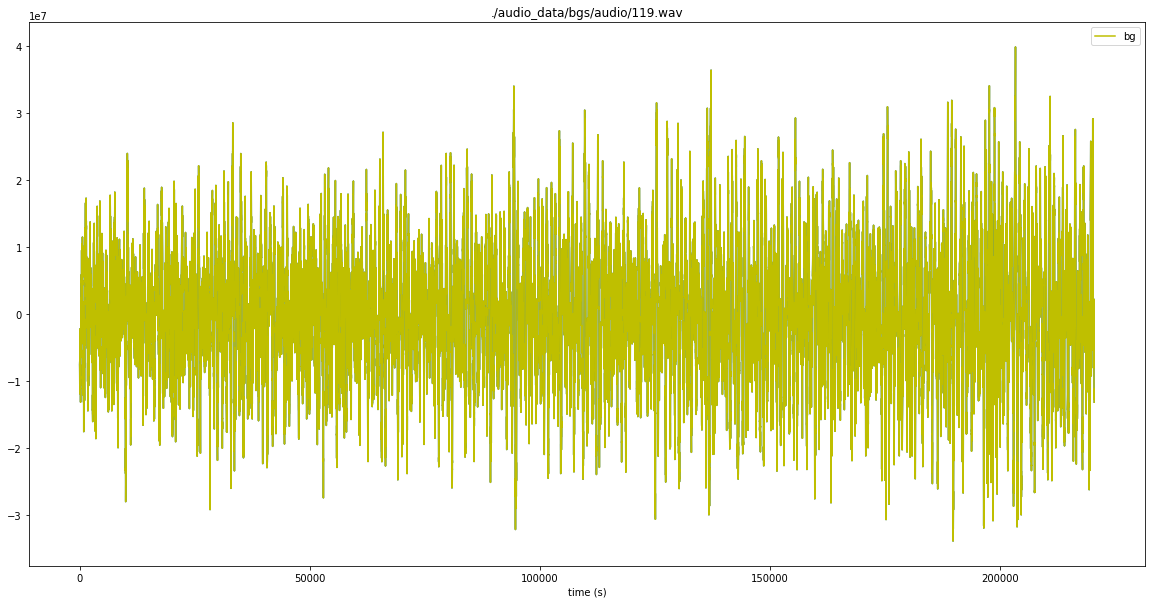

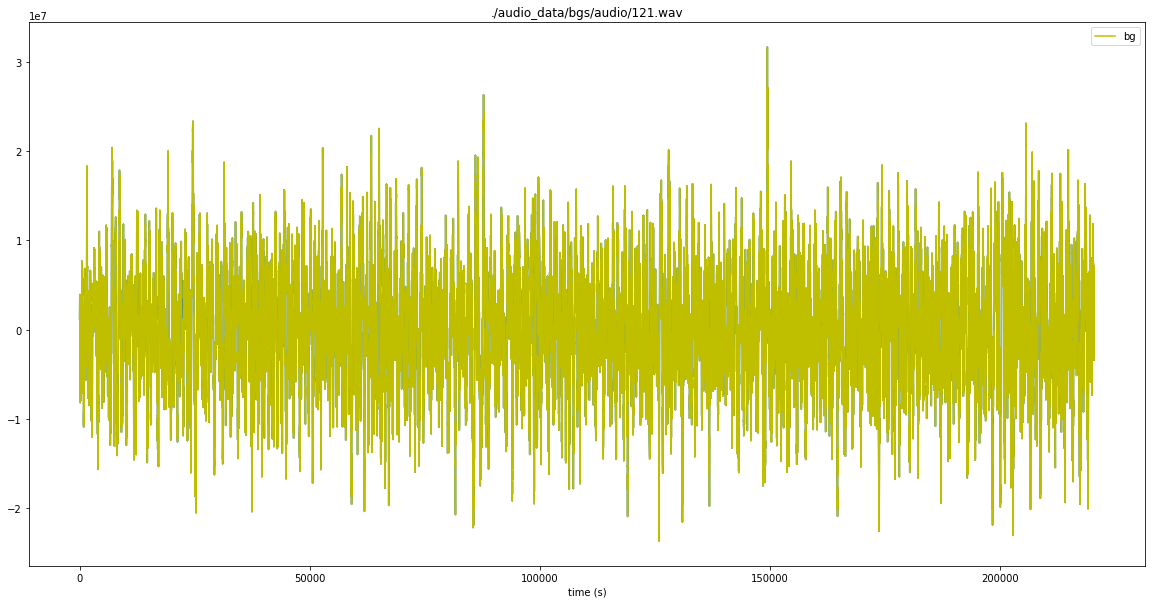

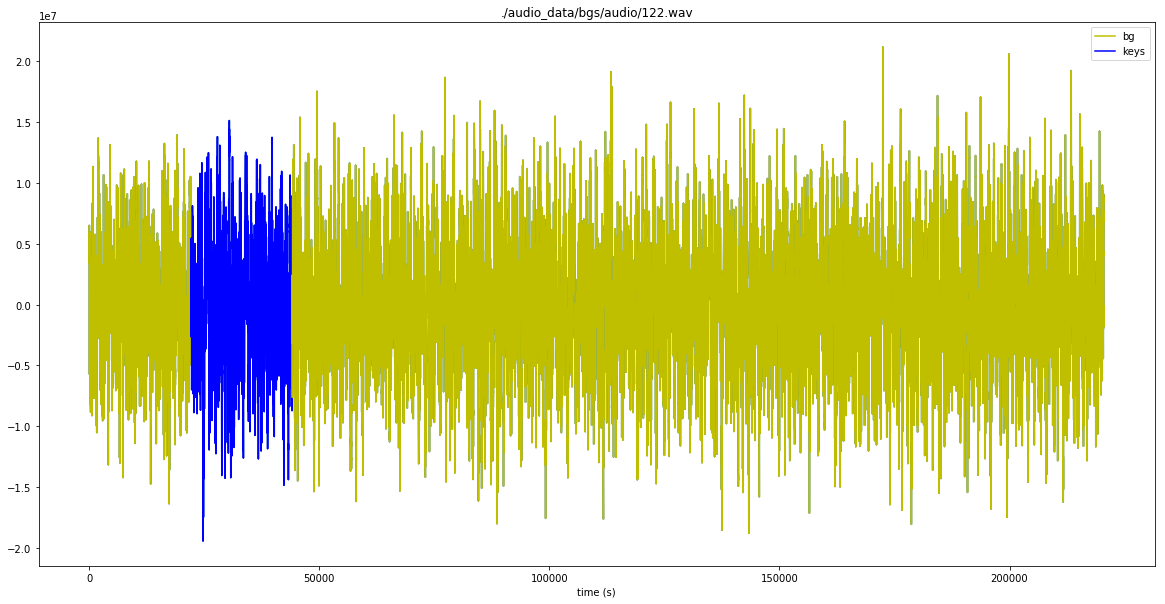

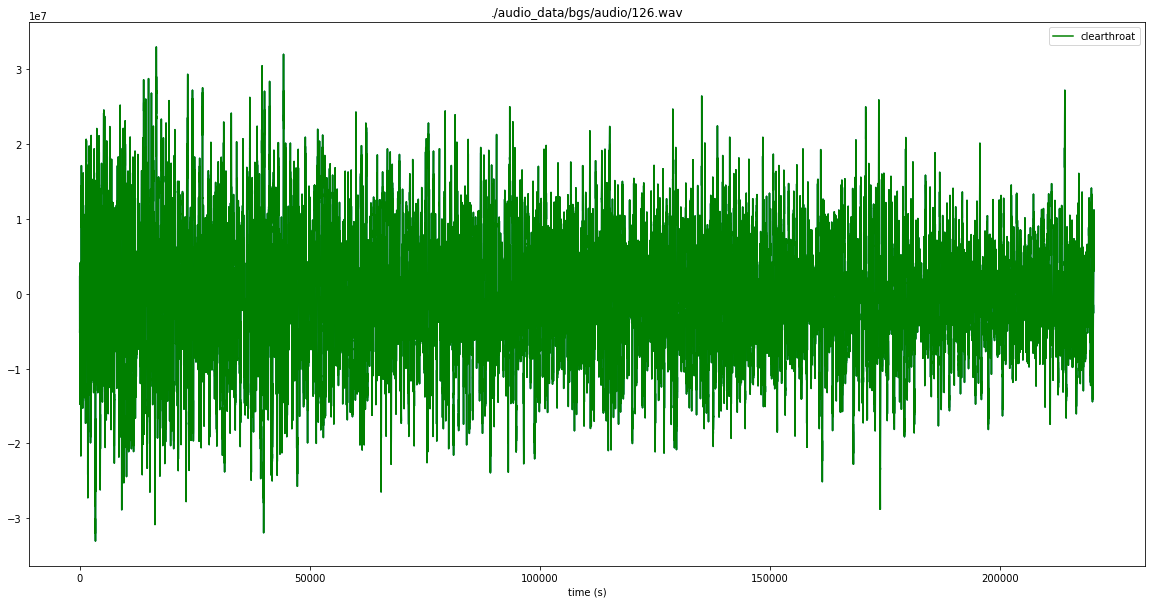

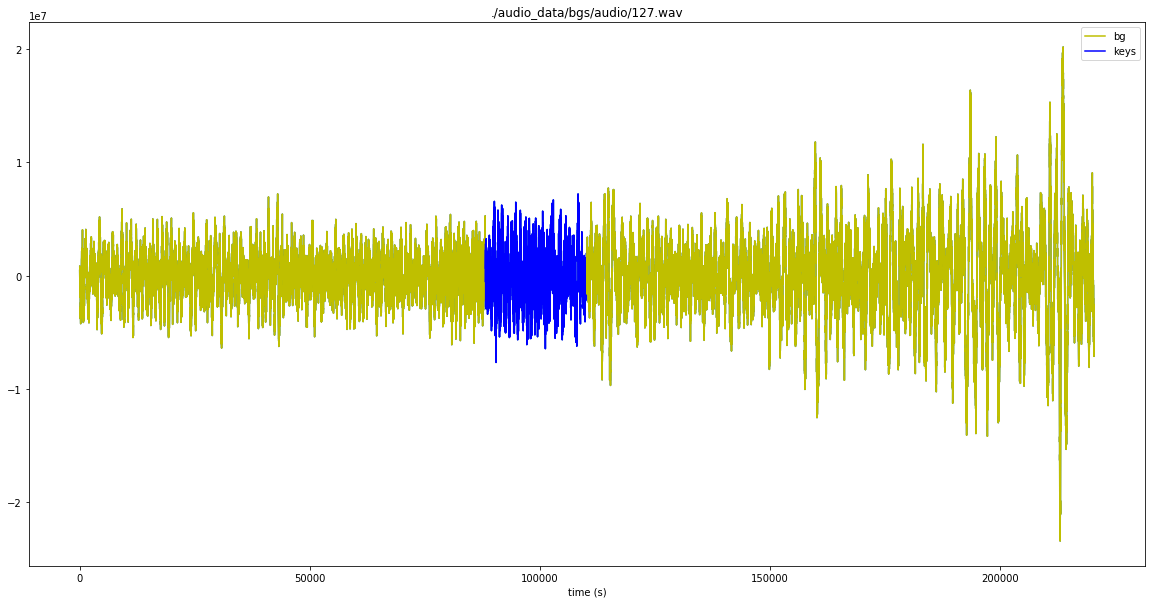

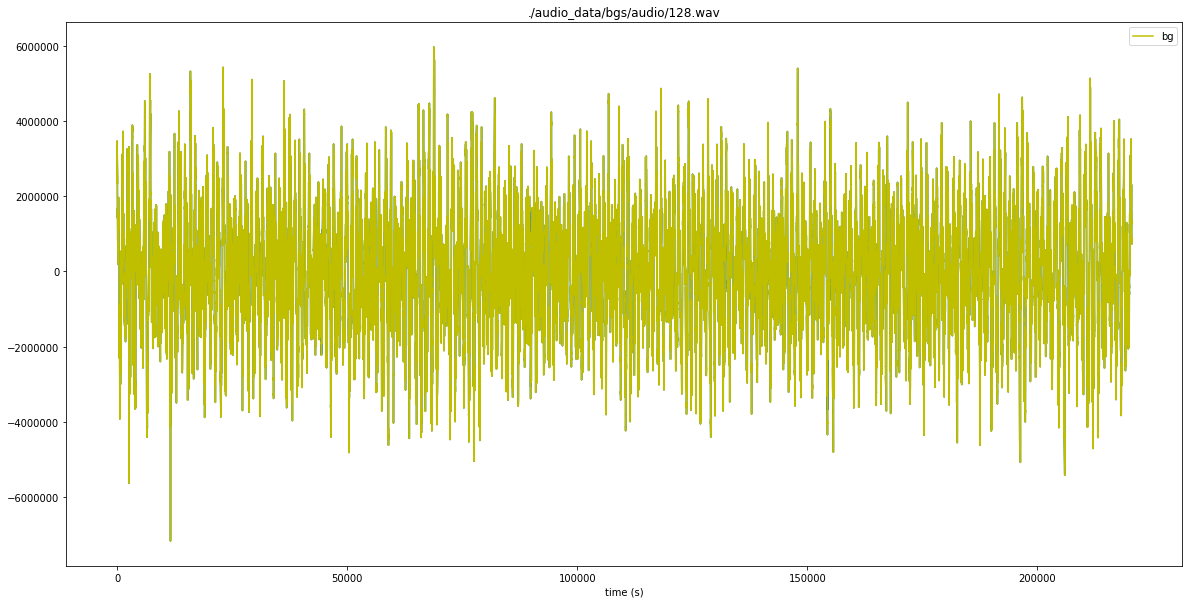

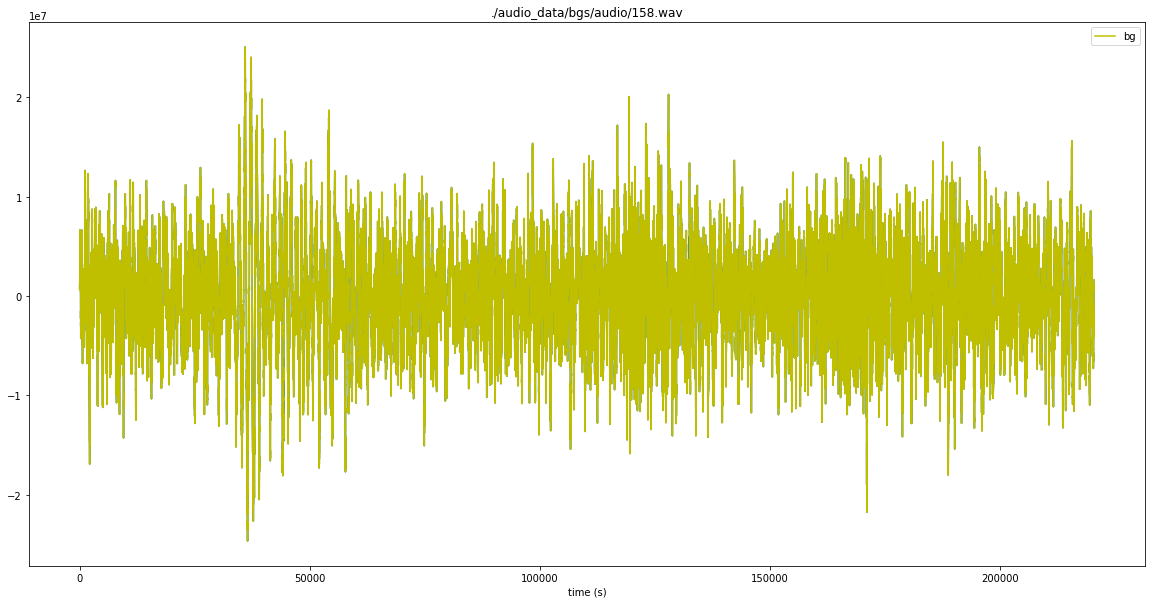

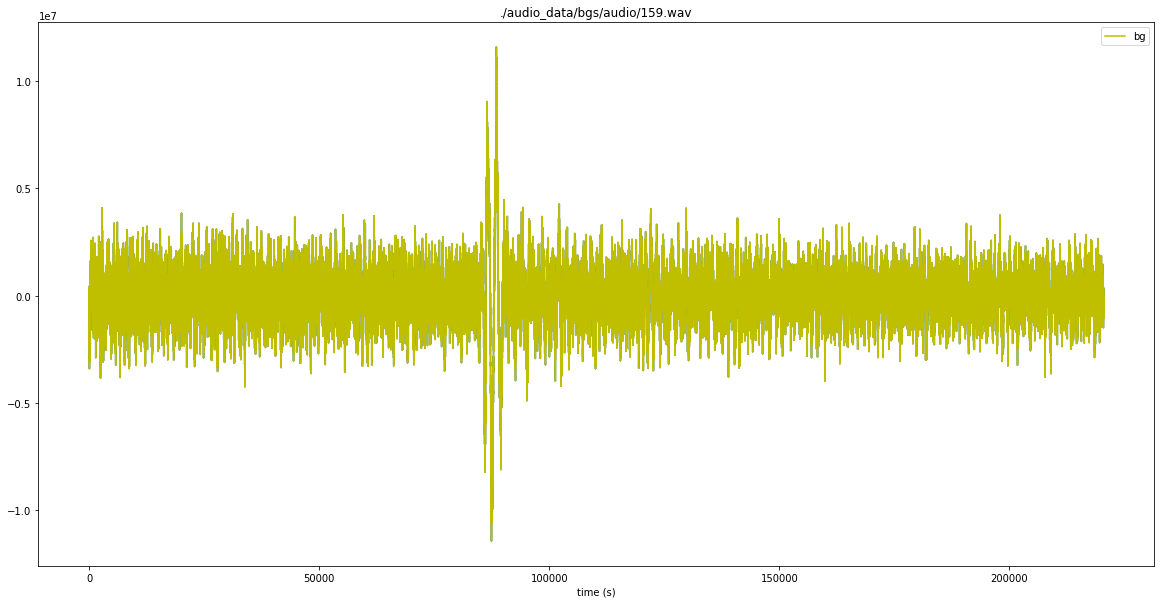

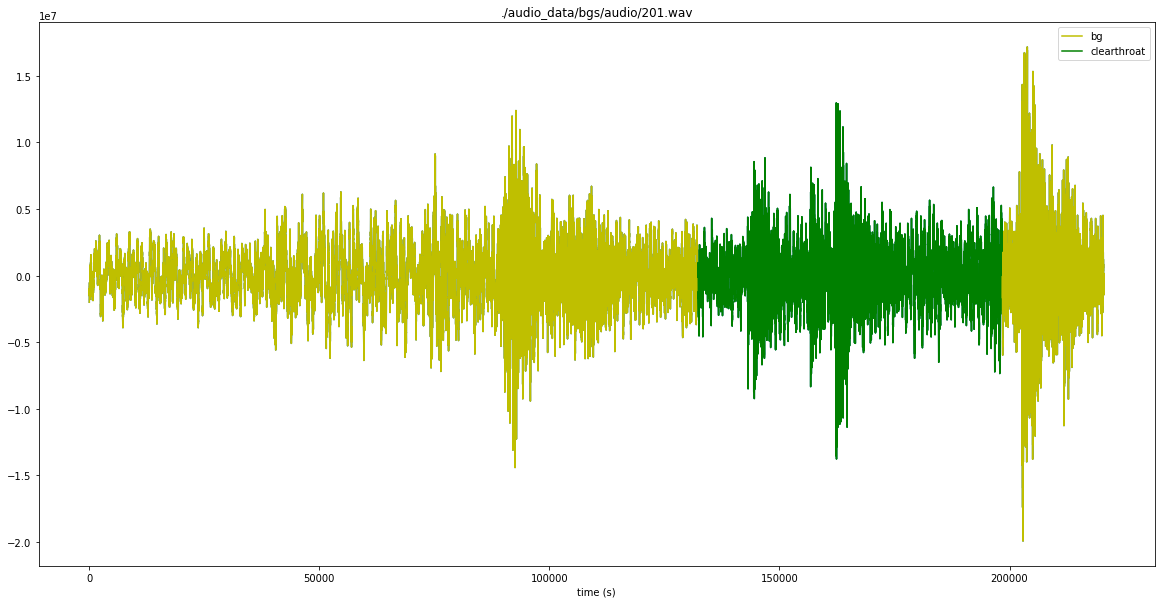

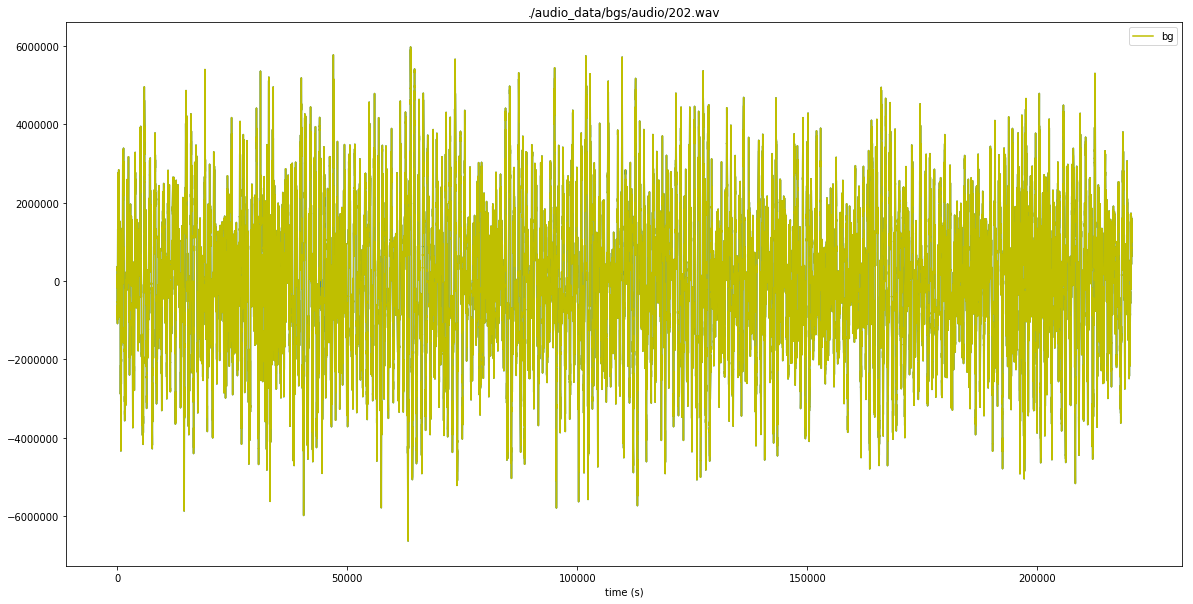

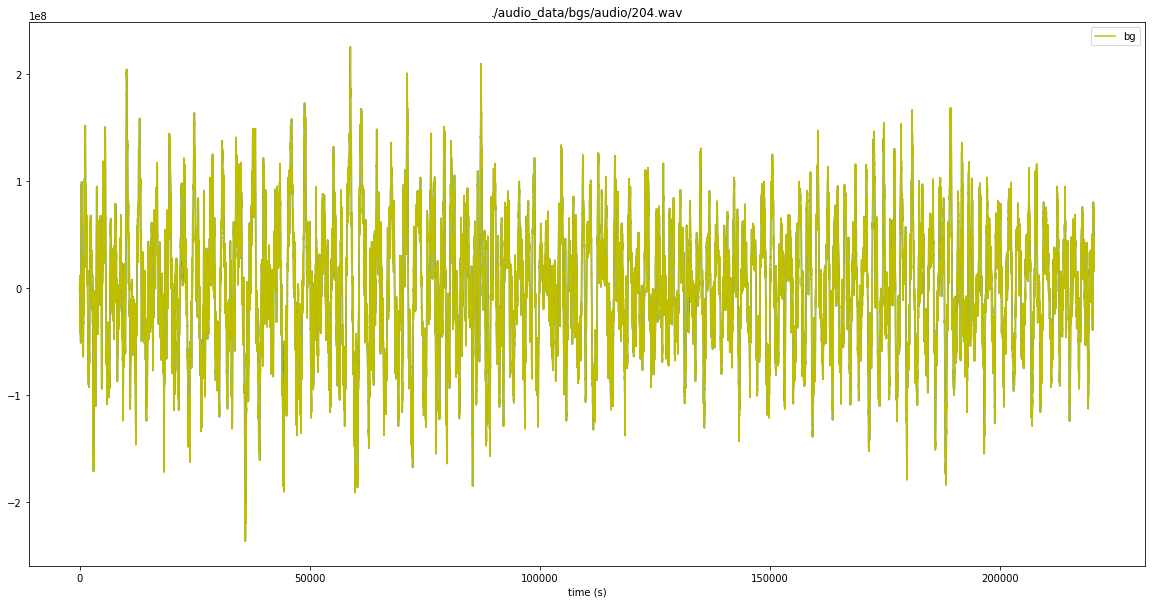

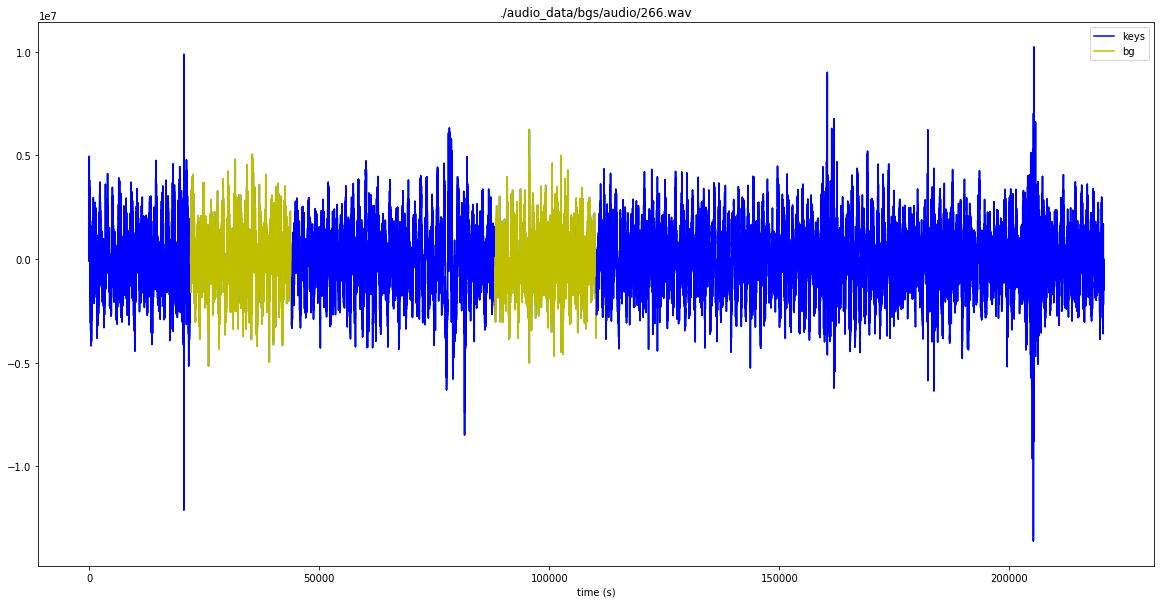

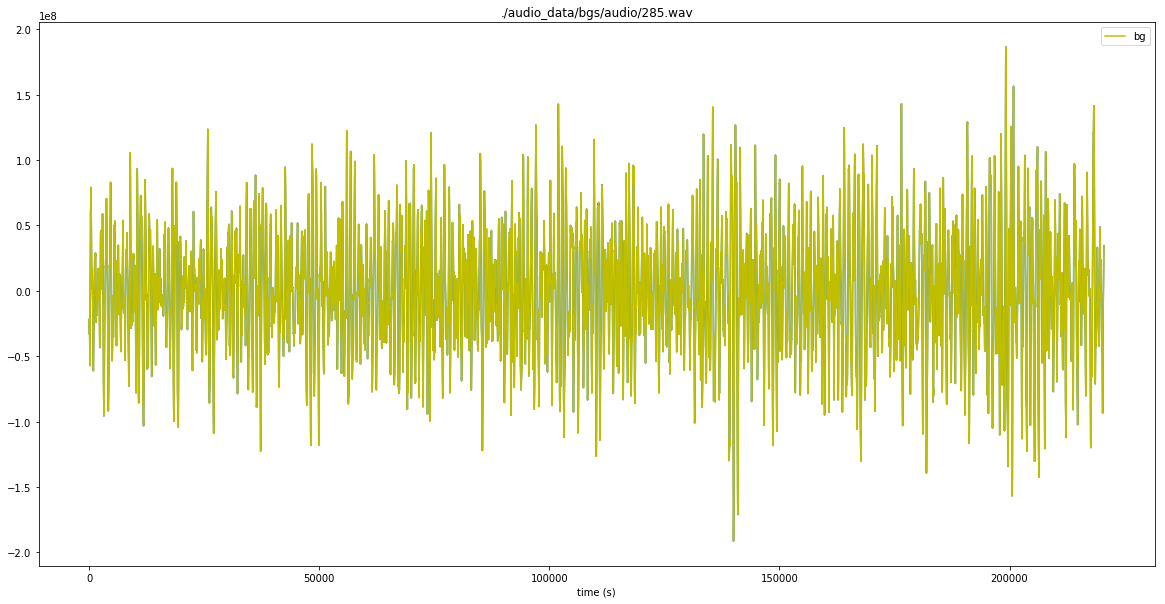

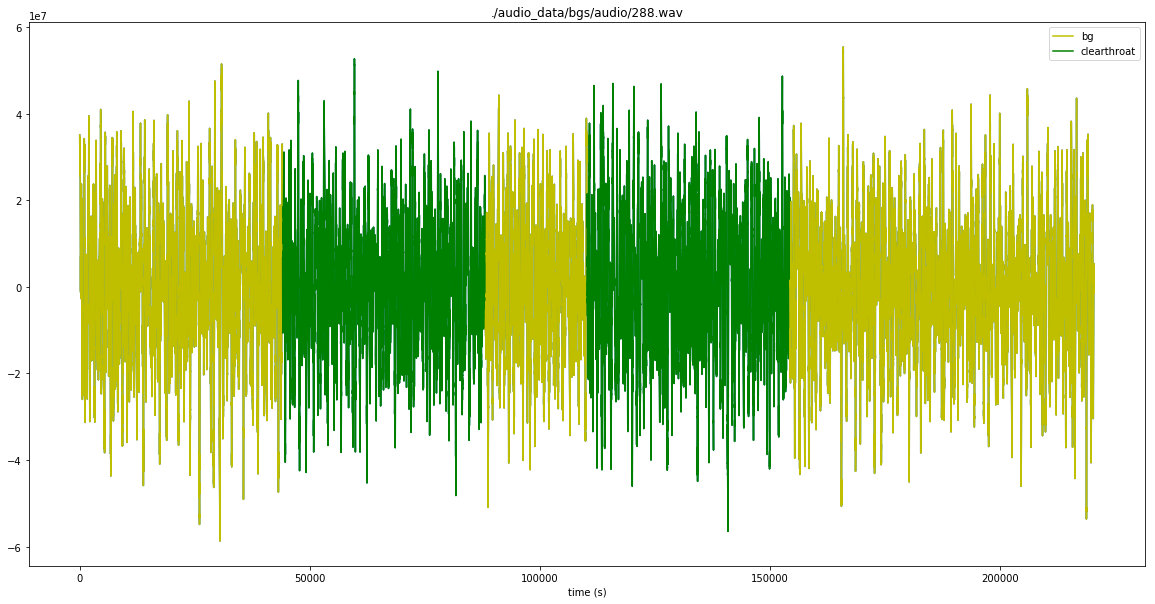

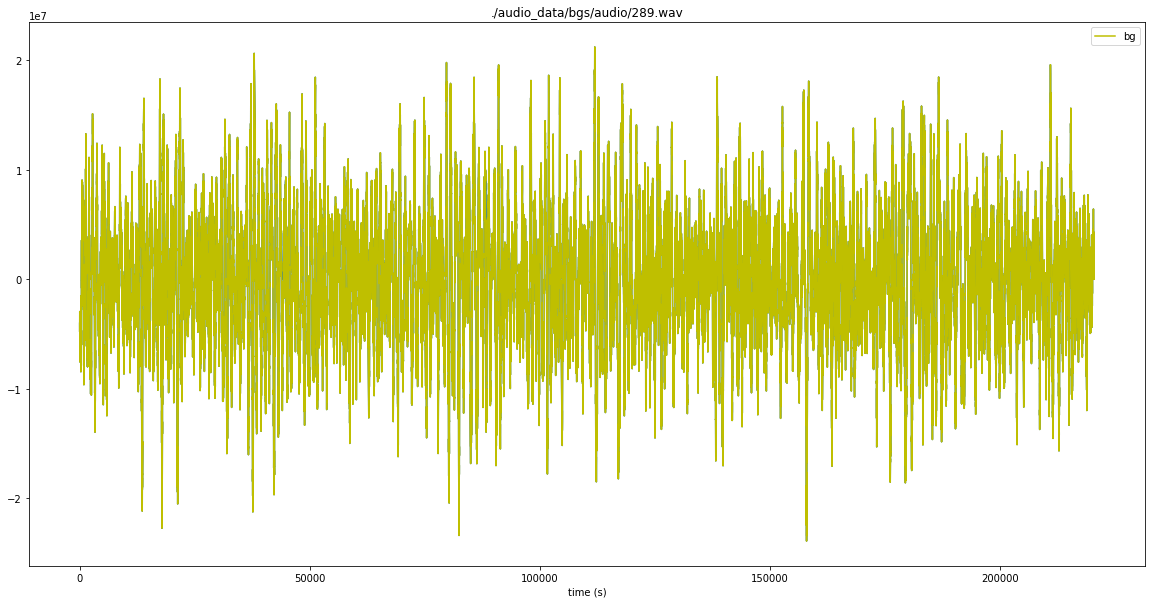

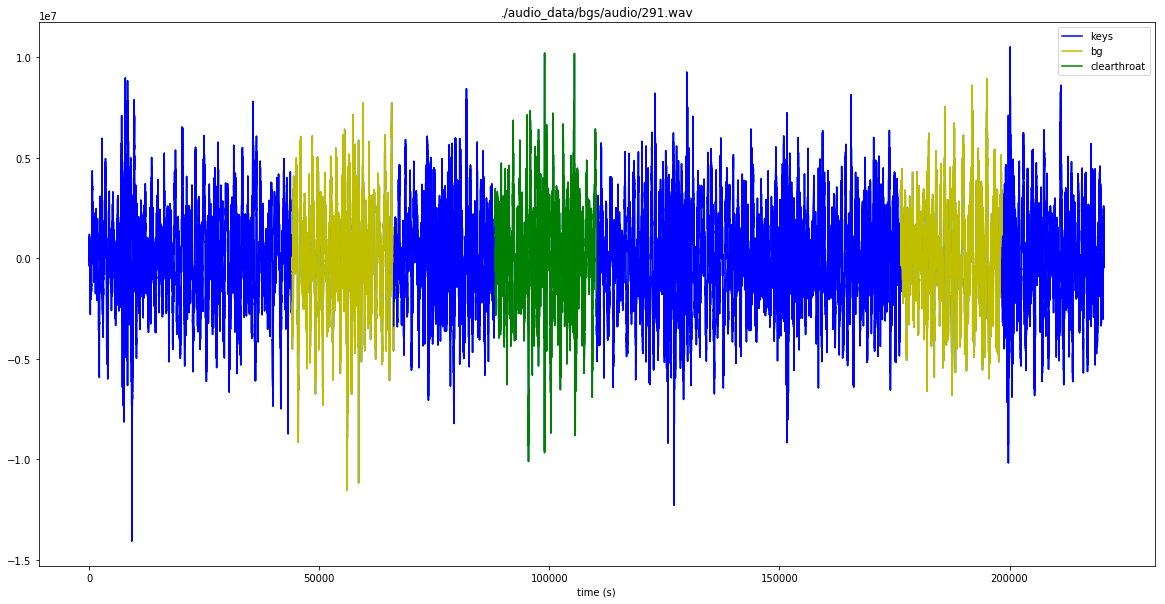

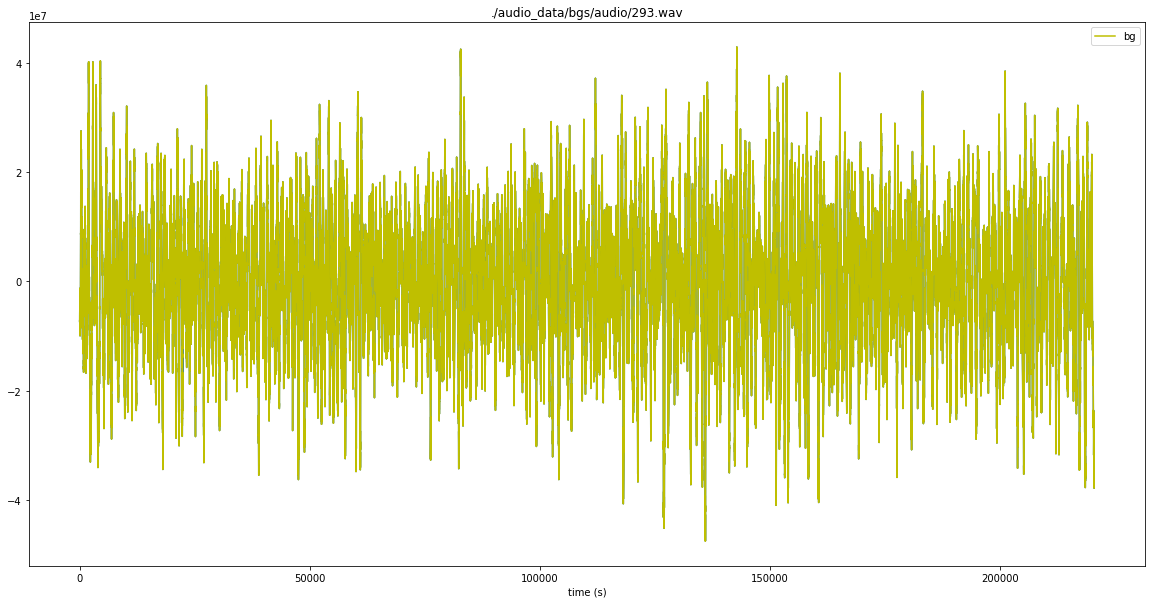

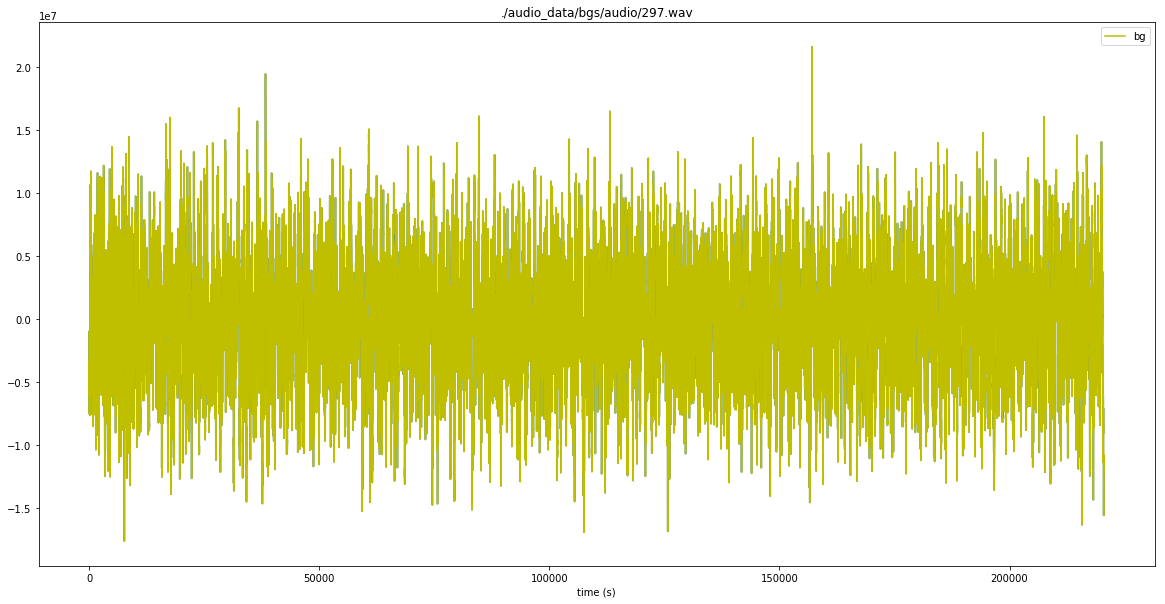

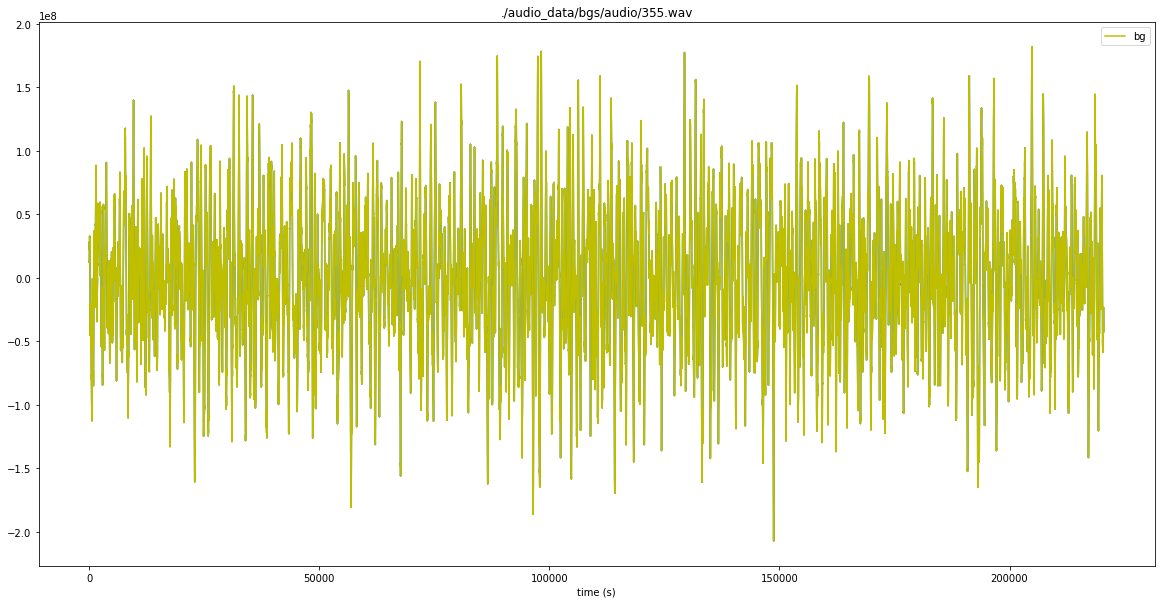

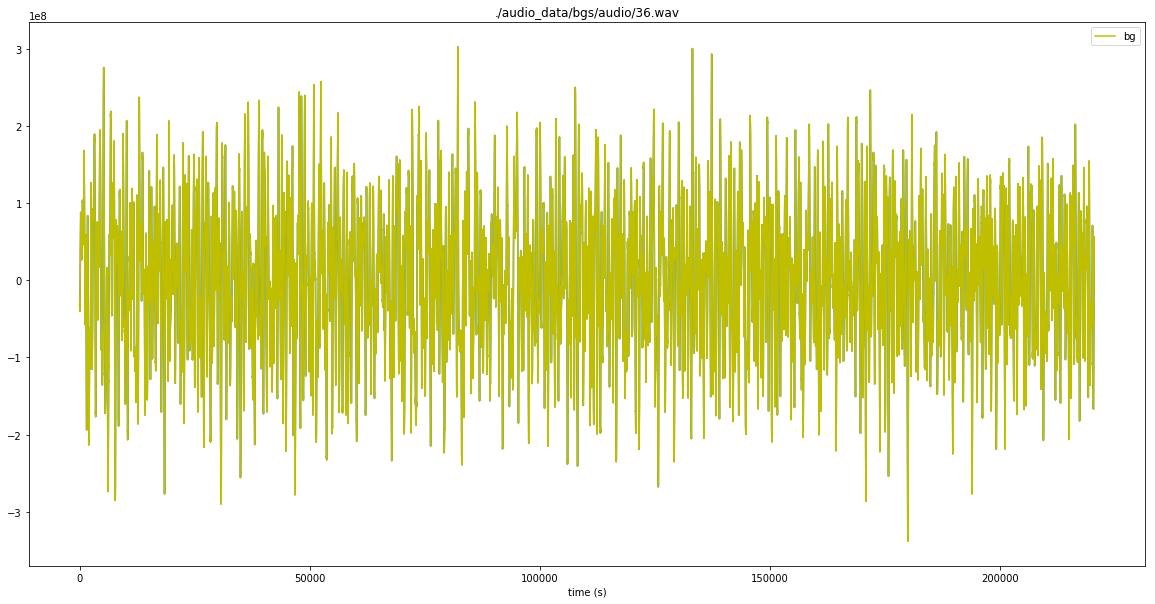

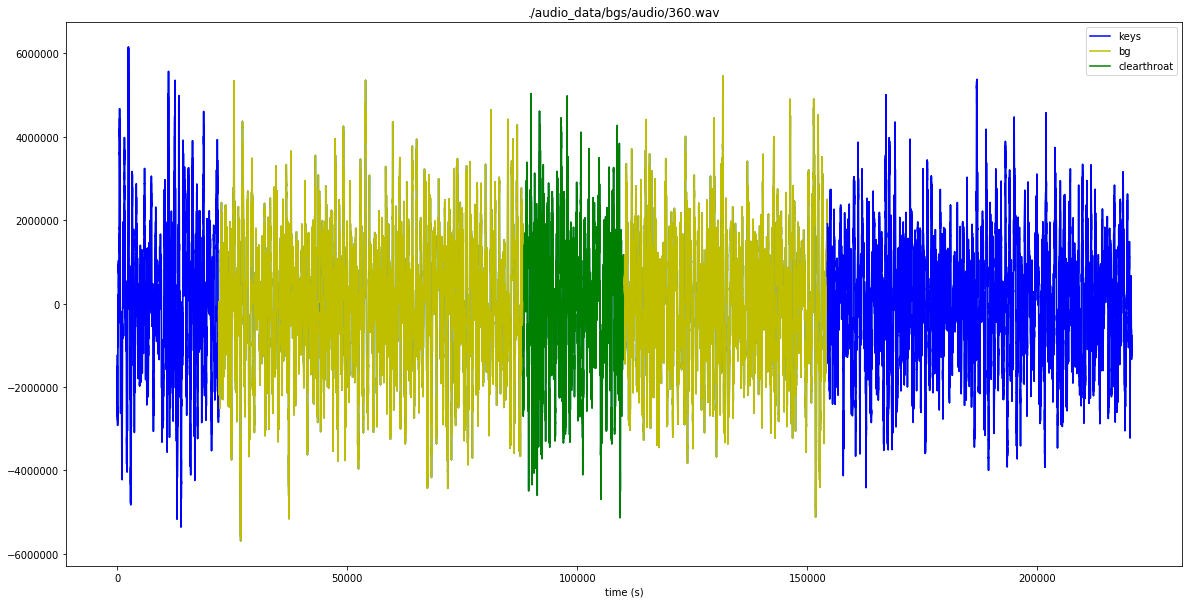

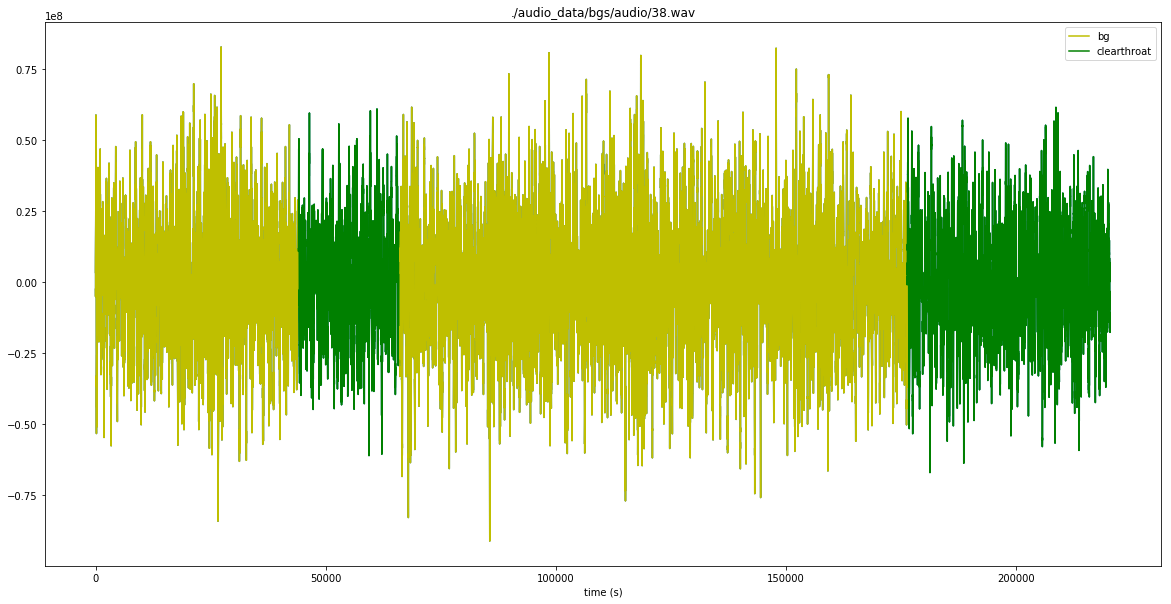

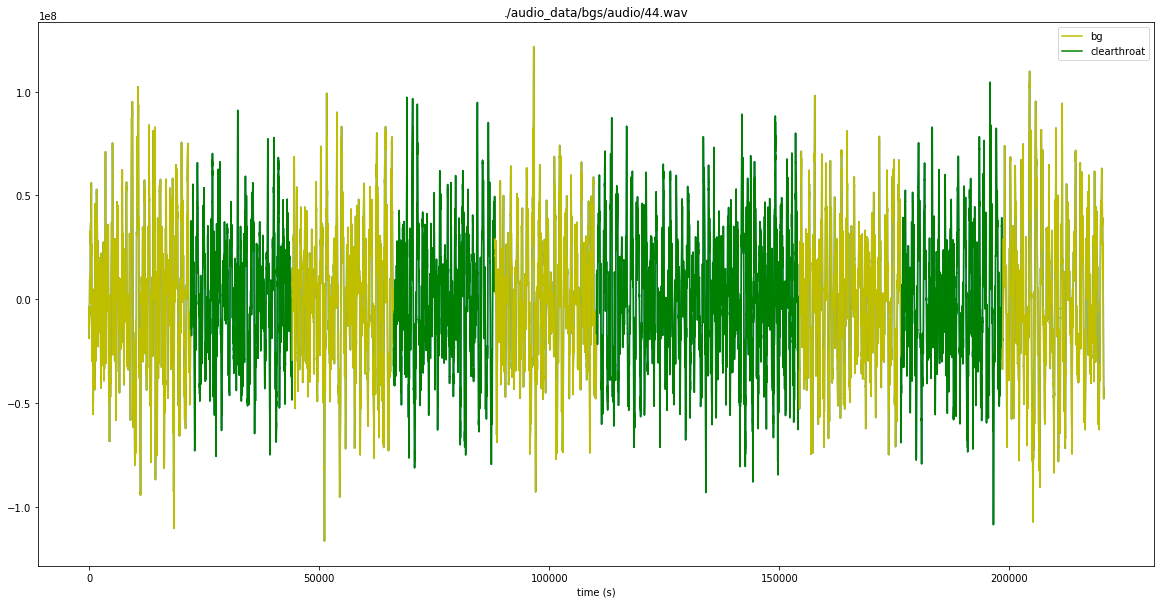

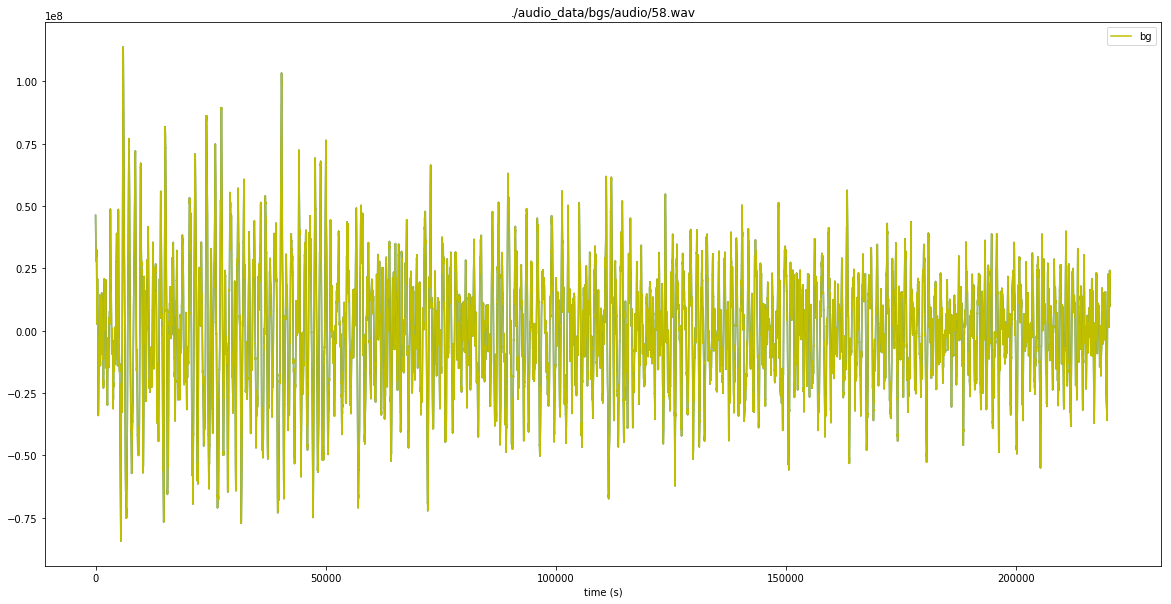

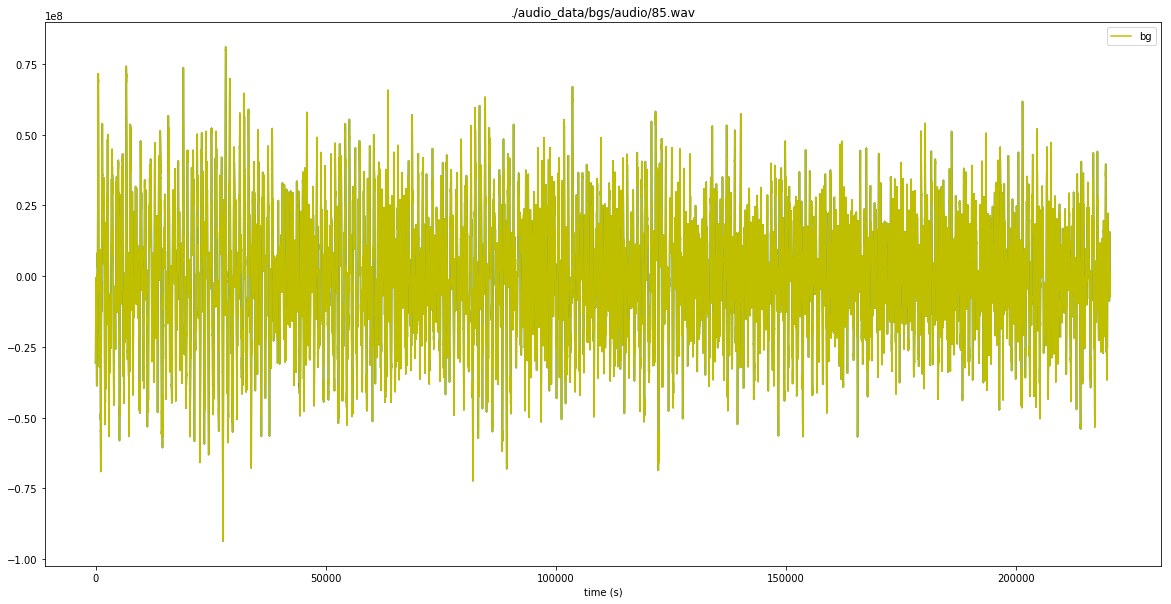

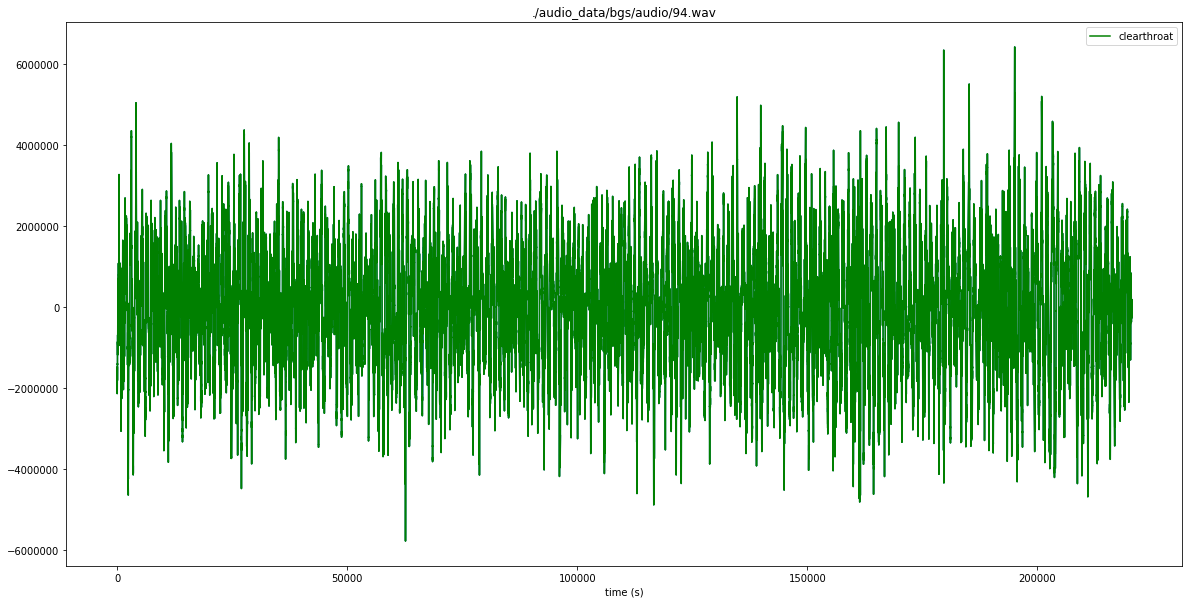

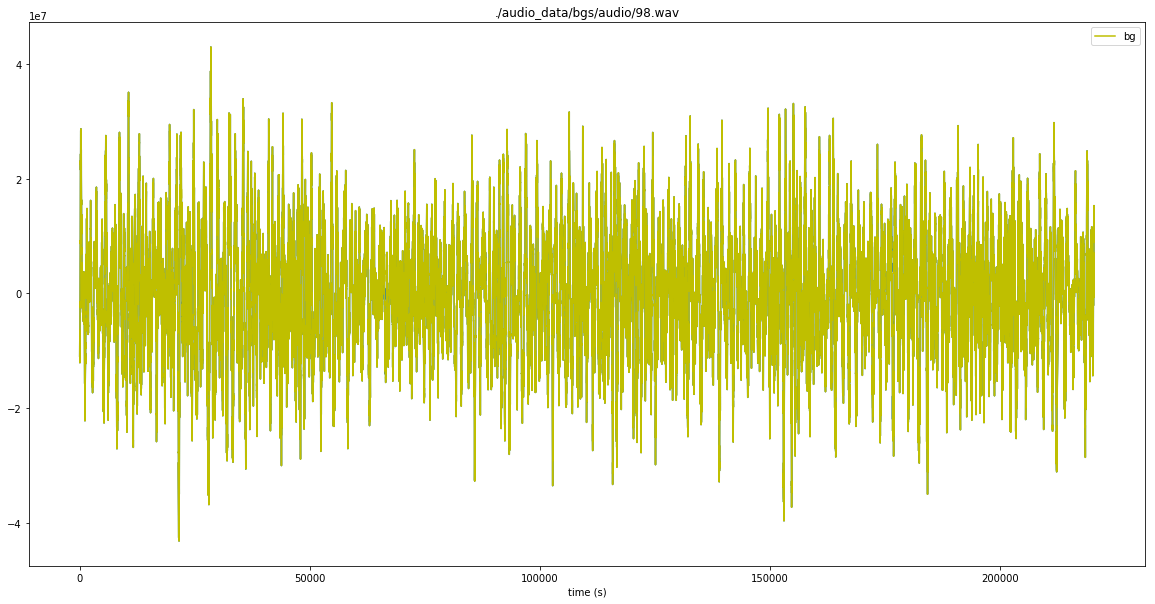

In [0]:
predict('./audio_data/bgs/audio/')

In [0]:
model.evaluate_generator(train_iterator(BATCH_SIZE), 100)

[0.14561602788483938, 0.9846875]